<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<hr>

# Discover Indonesian Fires 2019

Indonesia experiences each year forest fires, especially during the dry season between March and October, with the more severe fires occuring between July and September. Provinces that are often affected are west, central and south Kalimantan (Borneo island) as well as Riau, Jambi and South Sumatra. Read more about the causes and effects of the fires in this [BBC article](https://www.bbc.com/news/world-asia-34265922) describing the fires in 2019.

This workflow features fire occurences in west, central and south Kalimantan in 2019. The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the following data products:
<a id="top"></a>
- [Sentinel-3 OLCI - RGB](#sentinel3_olci)
- [Sentinel-5P TROPOMI - Carbon Monoxide (CO) - Level 2](#sentinel_5p_co)
- [Sentinel-5P TROPOMI - Ultraviolet Aerosol Index (UVAI) - Level 2](#sentinel_5p_uvai)



<br>

<img src='../img/Peatland-burning-Indonesia.jpeg' alt='Indonesian Fires 2020, source: https://www.climatechangenews.com/2020/08/18/forest-destruction-spiked-indonesia-coronavirus-lockdown/' align='center' width='60%'></img>

<i>Caption: A man tries to extinguish fire on peatland at a sanctuary reserve area inside an oil palm concession in Central Kalimantan.</i><br> Image from [climatechangenews.com](https://www.climatechangenews.com/2020/08/18/forest-destruction-spiked-indonesia-coronavirus-lockdown/) and taken by [Jurnasyanto Sukarno / Greenpeace/Flickr](https://www.flickr.com/photos/189493116@N08/50147213307/)

<hr>

#### Load required libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='sentinel3_olci'></a>Sentinel-3 OLCI Level 1 RGB

Sentinel-3 OLCI Level 1 RGB composites can highlight areas of smoke resulting from wildfires. Let us go through step by step to load Sentinel-3 OLCI Level 1 data and to build a RGB false color composite.

#### Load OLCI channel information into one xarray object with xarray's function `open_mfdataset`

You can load multiple files at once with the xarray function `open_mfdataset`. In the case of Sentinel-3 OLCI Level-1 data, you want to combine the data of all 21 channels into one xarray object. The structure of the single data files is equal, thus you can combine the data by coordinates by using the keyword argument `by_coords`.

In [4]:
import zipfile
with zipfile.ZipFile('../eodata/sentinel3/olci/2019/09/05/S3B_OL_1_EFR____20190905T021940_20190905T022240_20200113T113901_0179_029_274_3060_MR1_R_NT_002.zip', 'r') as zip_ref:
    zip_ref.extractall('../eodata/sentinel3/olci/2019/09/05/')

In [6]:
olci_dir = '../eodata/sentinel3/olci/2019/09/05/S3B_OL_1_EFR____20190905T021940_20190905T022240_20200113T113901_0179_029_274_3060_MR1_R_NT_002.SEN3/'


In [8]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes: (12/16)
    absolute_orbit_number:  7091
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-01-13T11:39:01Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2019-09-05T02:19:40.041019Z
    stop_time:              2019-09-05T02:22:40.008739Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

<br>

#### Load the geo-coordinates and retrieve the data for `latitude` and `longitude`

You might want to georeference the resulting RGB image. Thus, you can already load the `geo_coordinates.nc` file and retrieve `latitude` and `longitude` information.

In [9]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

#### Select the channels for the RGB composite

The function [select_channels_for_rgb](../functions.ipynb#rgb_channels) selects the chosen channels from the loaded xarray object. In this case, we select the channels `#17`, `#05` and `#02`. Those channels allow to build a false color composite that highlights healthy vegetation in red and also shows the fire smokes more prominently.

In [12]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')


#### Normalize the channels `red`, `green` and `blue`

The function [normalize](../functions.ipynb#normalize) normalizes the data values within a range between 0 and 1.

In [14]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

#### Stack the RGB channels into a multi-dimensional array with `np.dstack`

The next step is to combine the three channels `red`, `green` and `blue` into one array stack. You can use the function `np.dstack()` to combined numpy arrays into a stack.

In [15]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

#### Apply a histogram equalization 

A histogram equalization can improve the contrast of the resulting RGB composite. Thus, we use the function `equalize_adapthist` from the exposure module part of the ski-kit-learn library to equalize the image based on the data's histogram.

In [16]:
rgb = exposure.equalize_adapthist(rgb)

#### Map the rgb values onto a color array

If you want to visualize a georeferenced RGB image, you have to map the rgb values onto a color array with the following code:

In [17]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

#### Visualize the final RGB false color composite with the function `visualize_s3_pcolormesh`

Let us visualize the color array in a georeferenced way with the function [visualize_s3_pcolormesh](../functions.ipynb#visualize_s3_pcolormesh).

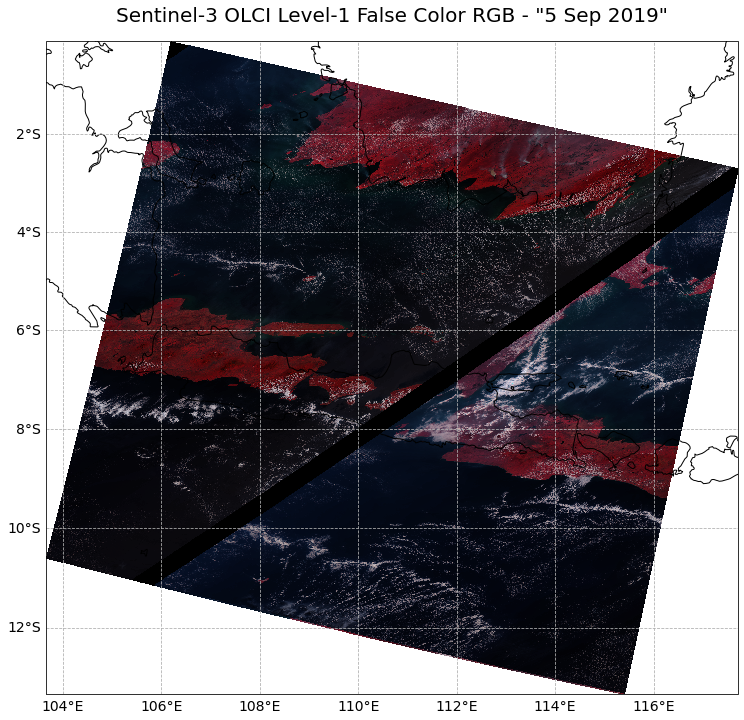

In [18]:
visualize_s3_pcolormesh(color_array=colorTuple, 
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 False Color RGB - "5 Sep 2019"')

^ [Return to the top](#top)

<br>

## <a id="sentinel_5p_co"></a> Sentinel-5P TROPOMI - Carbon Monoxide (CO) - Level 2

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbon monoxide`
* `Methane`
* `Clouds`

This section introduces the Sentinel-5P TROPOMI Carbon monoxide data and how it can be used to monitor wildfires.

### Load and browse a Sentinel-5P TROPOMI Carbon Monoxide data file

The first step is to load a Sentinel-5P TROPOMI Carbon Monoxide data file as `xarray.Dataset` with the `open_dataset()` function from the `xarray` library. You have to specify the keyword argument `group` in order to load the actual data values.

In [19]:
file = xr.open_dataset('../eodata/sentinel5p/co/2019/09/05/S5P_OFFL_L2__CO_____20190905T043705_20190905T061835_09815_01_010302_20190911T040028.nc', group='PRODUCT')
file

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 215, time: 1, corner: 4, layer: 50)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2019-09-05
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 4.95e+04 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 ...

<br>

### <a id='data_retrieve_s5p'></a>Retrieve the variable `carbonmonoxide_total_column` as xarray.DataArray

Load the variable of interest `carbonmonoxide_total_column`. You can do so by specifying the name of the variable and put it into square brackets `[]`.

In [20]:
co = file['carbonmonoxide_total_column']
co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2019-09-05
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

Repeat the previous step for the dimensions `latitude` and `longitude`.

In [21]:
latitude = co['latitude']
longitude = co['longitude']

<br>

Select the first time step by specifying the first value of the `time` dimension, i.e. `[0,:,:]`.

In [22]:
co_0509 = co[0,:,:]
co_0509

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2019-09-05
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

The attributes of the `xarray.DataArray` hold the entry `multiplication_factor_to_convert_to_molecules_percm2`. Let us save the multiplication factor as variable.

In [23]:
conversion_factor = co_0509.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

<br>

The next step is to apply the conversion factor to the `xarray.DataArray` to convert the Carbon Monoxide values from *mol per m<sup>2</sup>* to *molecules per cm<sup>2</sup>*.

In [24]:
co_0509_converted =  co_0509*conversion_factor
co_0509_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4172, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2019-09-05
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...

<br>

### Visualize Sentinel-5P TROPOMI Carbon Monoxide data

First, specify a `bounding box` set to the extent of Borneo.

In [25]:
latmin = -5
latmax = 8.
lonmin = 105.
lonmax = 120.

<br>

The last step is to visualize the Carbon Monoxide data for the specified region. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh).

Note: Multiplying the vmin and vmax values with 1e<sup>+18</sup> improves the readibility of the map legend. As vmin is already 0, there is no need to multiply it.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column 2019-09-05'}>)

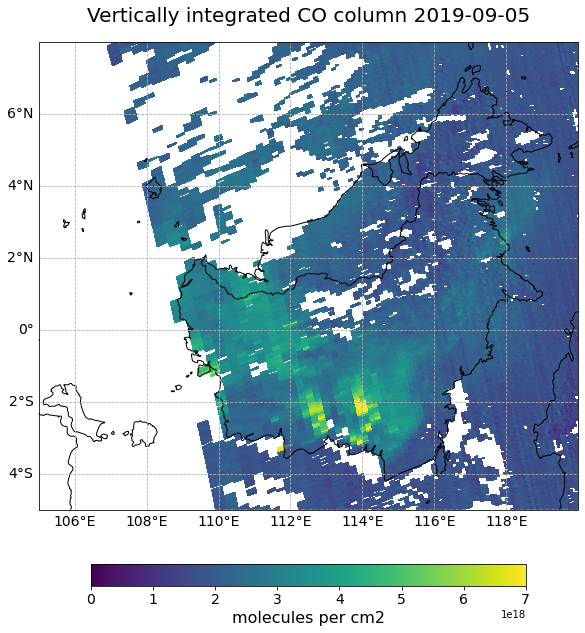

In [26]:
visualize_pcolormesh(data_array=co_0509_converted,
                     longitude=co_0509_converted.longitude,
                     latitude=co_0509_converted.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='viridis',
                     unit='molecules per cm2',
                     long_name=co_0509.long_name + ' ' + str(co_0509_converted.time.data)[0:10],
                     vmin=0, 
                     vmax=7*1e+18,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

^ [Return to the top](#top)

<br>

## <a id="sentinel_5p_uvai"></a> Sentinel-5P TROPOMI - Ultraviolet Aerosol Index (UVAI) - Level 2

For fire monitoring , the `TROPOMI UV Aerosol Index (UVAI)` data can be used. 

Positive values of UVAI (typically > abt. 1.0) indicate the presence of absorbing-type aerosols: 
- `smoke from forest fires`, 
- `volcanic ash`, or 
- `desert dust`. 



#### Load a Sentinel-5P TROPOMI UVAI data file

The first step is to load the Sentinel-5P TROPOMI UVAI data file. You can use the function `open_dataset()` from the xarray library to do so. You have to specify the keyword argument `group='PRODUCT'` in order to load the actual data values.

In [27]:
s5P_mf = xr.open_dataset('../eodata/sentinel5p/uvai/2019/09/05/S5P_OFFL_L2__AER_AI_20190905T043705_20190905T061835_09815_01_010302_20190911T040032.nc', group='PRODUCT')
s5P_mf

<xarray.Dataset>
Dimensions:                          (scanline: 4172, ground_pixel: 450, time: 1, corner: 4)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2019-09-05
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

### Select an `aerosol index` variable

The Sentinel-5p TROPOMI aerosol index data provide the Aerosol Index for two different wavelength pairs: 
- `340_380 nm`
- `354_388 nm` 

Select the data variable `aerosol_index_340_380` together with the geo-coordinates as follows:

In [28]:
uvai = s5P_mf.aerosol_index_340_380[0,:,:]
lat = uvai.latitude
lon = uvai.longitude


### Read the `Quality Flag` to mask the UVAI data

Another important parameter to read is the general quality flag called `qa_value`. The quality flag removes the sun glint pixels, where "falsely" high positive UVAI values over sea can be detected. In order to exclude sun glint, it is recommended to use only values where the `qa_value` is higher than 0.8. 

In [29]:
qa=s5P_mf.qa_value[0,:,:]

### Apply the qa value and mask the data

The final step before plotting is to mask the aerosol index data based on the qa mask. You filter data with the `xarray` function `where`.

In [30]:
uvai_masked=uvai.where(qa > 0.8)

### Visualize the `UV Aerosol Index` value

Specify a `bounding box` set to the island of Borneo.

In [31]:
latmin = -5
latmax = 8.
lonmin = 107.
lonmax = 120.

<br>

The final step is to visualize the gridded data with the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 380 and 340 nm 2019-09-05'}>)

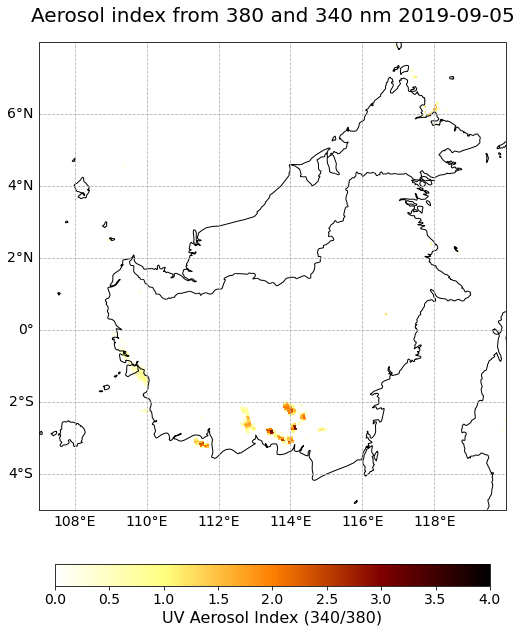

In [32]:
visualize_pcolormesh(data_array=uvai_masked,
                     longitude=lon,
                     latitude=lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit= 'UV Aerosol Index (340/380)',
                     long_name=uvai.long_name+ ' ' + str(uvai.time.data)[0:10],
                     vmin=0, 
                     vmax=4,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

## You have arrived at the end of this workflow highlighting the Indonesian fires during September 2019.

<br>

<img src='../img/indonesia_burnt_area.jpg' alt='Indonesian fires' align='centre' width='60%'></img>

<i>Caption: Burned land is pictured next to a palm oil plantation after fires near Banjarmasin in South Kalimantan province, Indonesia [Source: Willy Kurniawan/Reuters]</a>

^ [Return to the top](#top)

<br>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>